# Final Project 

In [136]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from scipy.stats import norm
from tabulate import tabulate
import requests
import yfinance as yf
from datetime import datetime
from dateutil.relativedelta import relativedelta
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression
import scipy.optimize as optimize
from scipy.stats import norm

/Users/zoeyzheng/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/Users/zoeyzheng/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


## Step 1 Data

In [39]:
#Self defined parameters 
N = 1000000
T = 3
delta = 3
k = 1
k_prime = 1
t = '2015-11-01'
start_date = datetime.strptime(t, '%Y-%m-%d').date() + relativedelta(years=T)
end_date = start_date + relativedelta(months=delta)
start_date = start_date.strftime('%Y-%m-%d')
end_date = end_date.strftime('%Y-%m-%d')

2018-11-01
2019-02-01


In [76]:
## data source: https://www.newyorkfed.org/markets/reference-rates/sofr-averages-and-index
sofr_data = pd.read_excel('SOFR.xlsx')

/Users/zoeyzheng/opt/anaconda3/lib/python3.8/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [64]:
stock_data = yf.download('^STOXX50E','2018-11-01','2023-11-01')

[*********************100%***********************]  1 of 1 completed


In [46]:
exchange_rate = yf.download('EURUSD=X','2018-11-01','2023-11-01')
exchange_rate

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-11-01,1.131388,1.141318,1.131375,1.131670,1.131670,0
2018-11-02,1.140277,1.145541,1.137566,1.140329,1.140329,0
2018-11-05,1.139705,1.140641,1.135525,1.139757,1.139757,0
2018-11-06,1.140862,1.143811,1.139328,1.141292,1.141292,0
2018-11-07,1.144099,1.149994,1.140056,1.143851,1.143851,0
...,...,...,...,...,...,...
2023-10-25,1.059535,1.060670,1.056680,1.059535,1.059535,0
2023-10-26,1.056725,1.056971,1.052632,1.056725,1.056725,0
2023-10-27,1.056446,1.059771,1.053630,1.056446,1.056446,0


## Step 2 Simulation Model

### Use historical data to calculate $\delta_f$, $\delta_x$, $\rho_{fx}$ and calculate $\sigma_s$

In [72]:
log_returns = np.log(stock_data['Close'] / stock_data['Close'].shift(1))
volatility = log_returns.std()
delta_f = volatility * np.sqrt(252)

log_returns = np.log(exchange_rate['Close'] / exchange_rate['Close'].shift(1))
volatility = log_returns.std()
delta_x = volatility * np.sqrt(252)

aligned_data = stock_data['Close'].align(exchange_rate['Close'], join='inner')

stock_returns = np.log(aligned_data[0] / aligned_data[0].shift(1))
exchange_rate_returns = np.log(aligned_data[1] / aligned_data[1].shift(1))

rho_fx = stock_returns.corr(exchange_rate_returns)

sigma_s = (delta_f**2 + delta_x**2 + 2 * delta_f * delta_x * rho_fx)**0.5

### Use Vasicek to simulate for SOFR 

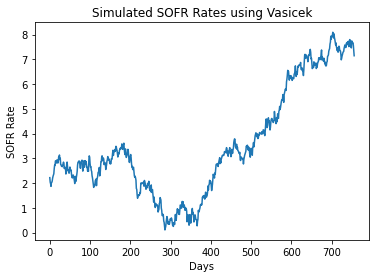

In [145]:
sofr_rates = sofr_data['Rate (%)'].copy()

changes = sofr_rates.diff().dropna()

b = np.mean(sofr_rates)

# Estimate a, b and sigma
def vasicek_log_likelihood(params, r):
    a, b, sigma = params
    dt = 1 / days 
    dr = np.diff(r)
    mu = a * (b - r[:-1]) * dt
    likelihoods = norm.logpdf(dr, mu, sigma * np.sqrt(dt))
    return -np.sum(likelihoods)
def vasicek_regression(rates, changes, b):
    initial_guess = [0.1, 0.05, 0.01]
    result = optimize.minimize(vasicek_log_likelihood, initial_guess, args=(rates,), method='L-BFGS-B')

    if result.success:
        a, b, sigma = result.x
    else:
        print("MLE fails to converge and Linear regression used")
        X = -1 * (rates[:-1] - b).values.reshape(-1, 1)
        y = changes.values

        model = LinearRegression()
        model.fit(X, y)
        a = -model.coef_[0]

        # Estimate sigma
        residuals = y - model.predict(X)
        sigma = np.std(residuals)
        
    return a, sigma, b


# Simulate Future SOFR Rates
def simulate_vasicek(a, b, changes, sigma, sofr_rates, days=days*T):
    dt = 1/252 
    rates = [sofr_rates.iloc[-1]]
    historical = sofr_rates
    for _ in range(days):
        a, sigma, b = vasicek_regression(historical, changes, b)
        dr = a * (b - rates[-1]) * dt + sigma * np.random.normal() * np.sqrt(dt)
        rates.append(rates[-1] + dr)
        historical[len(historical)] = rates[-1]
        changes = historical.diff().dropna()
        

    return rates

simulated_rates = simulate_vasicek(a, b, changes, sigma, sofr_rates)

# Step 5: Plot the Results
plt.plot(simulated_rates)
plt.title('Simulated SOFR Rates using Vasicek')
plt.xlabel('Days')
plt.ylabel('SOFR Rate')
plt.show()

In [126]:
# Transform daily SOFR to term SOFR 

### Use Dothan to simulate SOFR

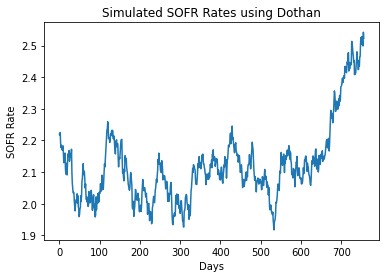

In [159]:
sofr_rates = sofr_data['Rate (%)'].copy()
log_returns = np.log(sofr_rates / sofr_rates.shift(1)).dropna()
def param_dothan(historical):
    log_returns = np.log(historical / historical.shift(1)).dropna()
    X = np.arange(len(log_returns)).reshape(-1, 1)
    model = LinearRegression().fit(X, log_returns)
    mu_est = model.intercept_
    sigma_est = np.std(log_returns - model.predict(X))  
    return mu_est, sigma_est

def simulate_dothan(r_T, sofr_rates, days=days*T):
    dt = 1 / 252  # Assuming daily data
    rates = [r_T]
    historical = sofr_rates
    for _ in range(days):
        mu, sigma = param_dothan(historical)
        dr = mu * rates[-1] * dt + sigma * rates[-1] * np.random.normal() * np.sqrt(dt)
        new = rates[-1] + dr
        rates.append(new)
        historical[len(historical)] = new
    return rates



r_T = sofr_rates.iloc[-1] 

# Run the simulation
simulated_rates = simulate_dothan(r_T, sofr_rates)

plt.plot(simulated_rates)
plt.title('Simulated SOFR Rates using Dothan')
plt.xlabel('Days')
plt.ylabel('SOFR Rate')
plt.show()

### Use GBM to simulate interest rate

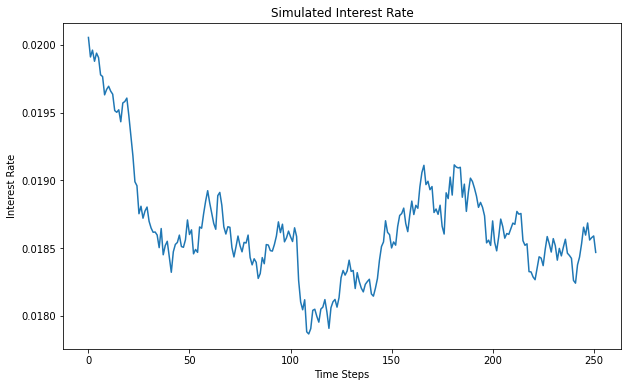

In [68]:
# Interest Rate simulation
interest_0 = 0.02  # Initial interest rate
mu_interest = 0.01  # Drift coefficient for interest rate
sigma_interest = 0.05  # Volatility coefficient for interest rate
days = 252
def simulate_gbm(S0, mu, sigma, T, days):
    """
    Simulate a GBM process

    :param S0: Initial value
    :param mu: Drift
    :param sigma: Volatility
    :param T: Time
    :param days: Number of trading days
    :return: GBM
    """
    dt = T / days
    t = np.linspace(0, T, days)
    W = np.random.standard_normal(size=days)
    W = np.cumsum(W) * np.sqrt(dt)  # Standard Brownian motion
    X = (mu - 0.5 * sigma ** 2) * t + sigma * W
    S = S0 * np.exp(X)  # GBM
    return S

# Simulating the Interest Rate
interest_rate_simulation = simulate_gbm(interest_0, mu_interest, sigma_interest, T, days)

# Plotting the simulated Interest Rate
plt.figure(figsize=(10, 6))
plt.plot(interest_rate_simulation)
plt.title("Simulated Interest Rate")
plt.xlabel("Time Steps")
plt.ylabel("Interest Rate")
plt.show()

### Calculate $\frac{S(T)}{S(0)}$ use simulated data

In [73]:
dt = 1/N
S0 = 1.336

W_T = np.random.normal(0, np.sqrt(T))

num_points = days # Number of data points
r_d = interest_rate_simulation

# Time points for the data series
time_points = np.linspace(0, T, num_points)

# Numerical integration of r_d(s) over [0, T]
integral_r_d = np.trapz(r_d, time_points)

# Second term, which simplifies to sigma_s^2 * T / 2
integral_sigma_s_squared = 0.5 * sigma_s**2 * T

# Third term, which is sigma_s * W_T
integral_sigma_s_W_T = sigma_s * W_T

# Combine the terms and calculate the exponential
variable_value = np.exp(integral_r_d - integral_sigma_s_squared + integral_sigma_s_W_T)
variable_value


1.9023995226248667

## Step 3 Price Calculation with market data

In [ ]:
### price calculation based on real date
def calculate_contract_price(N, start_date, end_date, T, Delta, k, Stock_Data, k_prime):
    """
    Calculate the price of the financial contract.

    Parameters:
    N (float): Notional in USD.
    L_0_T_Delta (float): 3-month USD forward rate between T and T + Delta observed at time 0.
    T (float): Maturity date in years.
    Delta (float): Settlement period in years (usually 0.25 years for 3 months).
    k (float): Relative strike price.

    Returns:
    float: Price of the contract.
    """
    S_0 = Stock_Data['Close'].loc[start_date]
    S_T = Stock_Data['Close'].loc[end_date]
    ''' 
    Forward rate calculationo and expectation
    L_T = 1
    L_0 = 1
    '''
    # Calculate the payoff at maturity
    payoff_at_maturity = max(0, ((k - S_T / S_0) * L_T/ L_0) - k_prime)

    # Calculate the contract price
    contract_price = N * payoff_at_maturity

    return contract_price